In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
import random
import string

import warnings
warnings.filterwarnings('ignore')

## Loading The Articles

In [2]:
import os  
path = '/Users/admin/Documents/SentenceCorpus/labeled_articles/'
all_files = os.listdir(path)

In [3]:
print(all_files)

['jdm_annotate3_120_1.txt', 'plos_annotate5_1375_2.txt', 'jdm_annotate2_107_1.txt', 'arxiv_annotate10_7_1.txt', 'plos_annotate5_1375_3.txt', 'plos_annotate10_1140_1.txt', 'plos_annotate10_1140_3.txt', 'plos_annotate5_1375_1.txt', 'jdm_annotate3_120_2.txt', 'jdm_annotate2_107_2.txt', 'arxiv_annotate10_7_3.txt', 'arxiv_annotate10_7_2.txt', 'jdm_annotate2_107_3.txt', 'jdm_annotate3_120_3.txt', 'plos_annotate10_1140_2.txt', 'plos_annotate7_1233_1.txt', 'arxiv_annotate7_268_3.txt', '.DS_Store', 'jdm_annotate4_220_3.txt', 'jdm_annotate4_220_2.txt', 'arxiv_annotate9_279_1.txt', 'arxiv_annotate7_268_2.txt', 'plos_annotate8_123_1.txt', 'plos_annotate7_1233_2.txt', 'plos_annotate8_123_3.txt', 'arxiv_annotate9_279_3.txt', 'jdm_annotate4_220_1.txt', 'arxiv_annotate9_279_2.txt', 'arxiv_annotate7_268_1.txt', 'plos_annotate8_123_2.txt', 'plos_annotate7_1233_3.txt', 'jdm_annotate10_210_3.txt', 'arxiv_annotate5_240_1.txt', 'jdm_annotate10_210_2.txt', 'arxiv_annotate5_240_2.txt', 'arxiv_annotate5_240_3.

In [4]:
all_files = [file for file in all_files if file != '.DS_Store']

In [5]:
articles = pd.DataFrame(np.zeros(4000))
num = 0

for file in all_files: 
    doc = open(path+file)
    read = doc.readlines()
    end = len(read)
    new_array = np.array([[line] for line in read if (line != '### abstract ###\n' and line != '### introduction ###\n')])
    end = len(new_array)-1
    articles.loc[num:num+end] = new_array
    num+=end
       

In [6]:
articles = articles[articles[0]!= 0]

In [7]:
articles.head()

,0
0,AIMX\twe test in the context of a dictator gam...
1,OWNX\twe manipulated the likelihood that indiv...
2,OWNX\tour analysis reveals a positive and sign...
3,OWNX\tthe magnitude of the effect is of econom...
4,OWNX\twe conclude that subtle cues might prove...


In [8]:
articles.shape

(3028, 1)

## Cleaning The Sentences

In [9]:
import re

pattern = re.compile(r'\b[A-Z]+\b')

In [10]:
def splitter(row):
    pattern = re.compile(r'\b[A-Z]+\b')   
    #if the article follows the \t format
    try:
        first_part, second_part = row[0].split('\t')
        
    #if the article doesn't follow the \t format
    except (ValueError, TypeError):
        #match the pattern and extract the index
        #print(pattern.match(list(row)[0]).span()[1])
        div_index = pattern.match(list(row)[0]).span()[1]
        first_part, second_part = row[0][:div_index], row[0][div_index+1:]
    print('ONE!!!', first_part, 'TWO!!!!', second_part)
    return second_part, first_part

In [11]:
labels = []
texts = []
for row in articles[0]:
    try:
        first_part, second_part = row.split('\t')
        
    #if the article doesn't follow the \t format
    except (ValueError, TypeError):
        #match the pattern and extract the index
        div_index = pattern.match(row).span()[1]
        first_part, second_part = row[:div_index], row[div_index+1:]
    labels.append(first_part.strip())
    texts.append(second_part.strip())

In [12]:
len(labels)

3028

In [13]:
articles['texts'] = texts
articles['labels'] = labels

In [14]:
articles.head()

,0,texts,labels
0,AIMX\twe test in the context of a dictator gam...,we test in the context of a dictator game the ...,AIMX
1,OWNX\twe manipulated the likelihood that indiv...,we manipulated the likelihood that individuals...,OWNX
2,OWNX\tour analysis reveals a positive and sign...,our analysis reveals a positive and significan...,OWNX
3,OWNX\tthe magnitude of the effect is of econom...,the magnitude of the effect is of economic sig...,OWNX
4,OWNX\twe conclude that subtle cues might prove...,we conclude that subtle cues might prove suffi...,OWNX


In [15]:
len(texts)

3028

## Unique Data - Removal of Duplicate Sentences

It turns out that a large portion of the sentences appears in more than one article. For more accurate modelling, we will remove all such sentences from the data set.

In [16]:
#apparently not all sentences in our data set are unique
articles['texts'].nunique()

1293

In [17]:
articles = articles.iloc[:, 1:]

In [18]:
articles.nunique()

texts     1293
labels       5
dtype: int64

In [19]:
no_dup_articles = articles.drop_duplicates(subset=['texts'])

In [20]:
no_dup_articles.nunique()

texts     1293
labels       5
dtype: int64

## Train Test Split

In [21]:
X = no_dup_articles['texts']
y=no_dup_articles['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=108)

In [22]:
len(X_train)

905

In [23]:
len(X_test)

388

## Class Imbalance

In [24]:
np.unique(y_train, return_counts=True)

(array(['AIMX', 'BASE', 'CONT', 'MISC', 'OWNX'], dtype=object),
 array([ 61,  21,  51, 535, 237]))

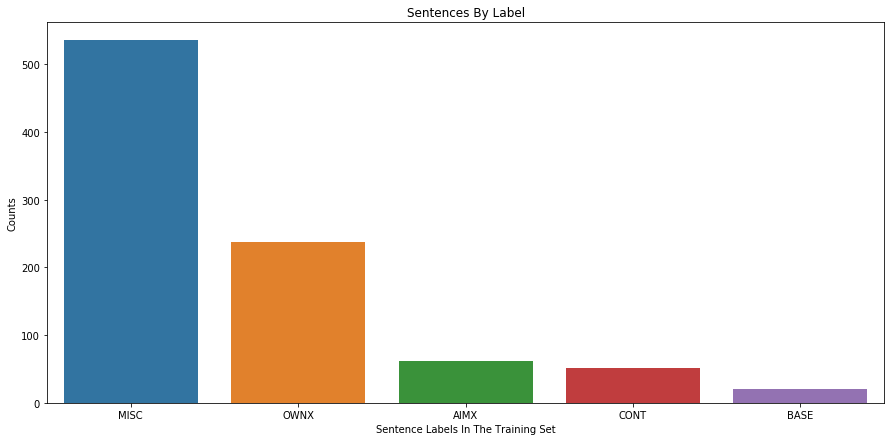

In [25]:
plt.figure(figsize=(15,7))

sns.countplot(x=y_train)
plt.title('Sentences By Label')
plt.xlabel('Sentence Labels In The Training Set')
plt.ylabel('Counts')
plt.show()

In [438]:
#preprocessing

nlp = spacy.load('en')

# since we have a rather small corpus, it makes sense to lemmatize all words

def processor(data, lemmatize=True):
    lemmas = []
    for entry in data:
        entry_parsed = nlp(entry)
        string = ''
        for token in entry_parsed:
            if (not token.is_punct
                and not token.is_stop # remove all the stop words
                and token.pos_ !='NUM'): 
                if lemmatize ==True:
                    string += token.lemma_ + ' '
                else:
                    string += str(token)+ ' '
                string = string.replace('-', '')
                string = string.replace('PRON', '')
                
        lemmas.append(string.rstrip())
 
    return lemmas


In [ ]:
X_train_processed = processor(X_train)

In [293]:
X_train_processed[:5]

['importantly iapp rodent specie rat mouse iapp lose capacity aggregate amyloid fibril citation transgenic mouse model express human iapp develop islet deposit citation',
 ' obvious proof paper conditionaliz',
 'case low likelihood slope expect weakly positive',
 'furthermore convert mathematical model quantitatively integrate gene expression datum reaction constraint compute functional network state compare report experimental datum',
 'in paper introduce radically new approach base machine learning technique map ases internet natural as taxonomy']

In [294]:
X_test_processed = processor(X_test)

### One-Hot Encoding for Classes

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)

In [29]:
y_test_encoded = encoder.transform(y_test)

## Oversampling

In [30]:
X_train_concat = pd.DataFrame({'texts': X_train_processed, 'classes': y_train_encoded})

In [31]:
X_train_concat.head()

,texts,classes
0,importantly iapp from rodent specie such as ra...,3
1,be not obvious if and how the proof in this p...,4
2,in the case of low likelihood the slope be exp...,4
3,furthermore be convert into a mathematical mo...,4
4,in this paper introduce a radically new appro...,0


In [32]:
np.unique(X_train_concat['classes'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 61,  21,  51, 535, 237]))

In [33]:
# resampling data to tackle class imbalance

X_train_zero = (X_train_concat[X_train_concat['classes']==0]).sample(535, random_state=108, replace=True)
X_train_one = (X_train_concat[X_train_concat['classes']==1]).sample(535, random_state=108, replace=True)
X_train_two = (X_train_concat[X_train_concat['classes']==2]).sample(535, random_state=108, replace=True)
X_train_three = X_train_concat[X_train_concat['classes']==3]
X_train_four = (X_train_concat[X_train_concat['classes']==4]).sample(535, random_state=108, replace=True)

In [38]:
X_train_balanced_over = pd.concat([X_train_zero
                                  ,X_train_one
                                  ,X_train_two
                                  ,X_train_three 
                                  ,X_train_four], axis=0, ignore_index=True)

In [ ]:
X_train_balanced_over.shape

In [ ]:
X_train_balanced_over = X_train_balanced_over.sample(2675)

In [39]:
np.unique(X_train_balanced_over['classes'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([535, 535, 535, 535, 535]))

## Feature Generation Strategy 1:
## Binary Features for Words in the Vocabulary

We will experiment with three training sets: original, with minority classes oversampled, and with majority classes undersampled.

In [40]:
path_lists = '/Users/admin/Documents/SentenceCorpus/word_lists/'
all_lists = os.listdir(path_lists)

all_lists = [file for file in all_lists if (file != '.svn' and file != '.DS_Store' and file != 'stopwords.txt')]

vocabulary = []

for file in all_lists: 
    doc = open(path_lists+file)
    read = doc.readlines()
    read = [word.replace('\n', '') for word in read]
    vocabulary.extend(read)

vocab_set = set(vocabulary)

### a) Creation of Binary Features for the Balanced Training Set

In [41]:
#creating features for the training set
for word in vocab_set:
    X_train_balanced_over[str(word)] = X_train_balanced_over['texts'].str.contains(
      ' ' +  str(word) + ' ',
        case=False
   )

In [42]:
X_train_balanced_over.head()

,texts,classes,demonstrate,capture,without,observe,future,sparse,typically,significantly,...,interested,extended,shortcomings,identify,is,hypothesis,tailored,refined,establish,although
0,to discover broad relationship between regulat...,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,this paper study quantum anneal qa for clu...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,in this paper attempt a more direct test of t...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,in this paper formalize discuss and motiv...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,on the basis of the prospect theory value func...,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
y_train_balanced_over_encoded = X_train_balanced_over['classes']

In [44]:
#select only the vocabulary portion, no texts or classes
X_train_binarized_vocab_over = X_train_balanced_over.iloc[:, 2:]

In [45]:
X_train_binarized_vocab_over = X_train_binarized_vocab_over.reset_index()

In [46]:
X_train_binarized_vocab_over = X_train_binarized_vocab_over.drop(['index'], axis=1)

In [47]:
X_train_binarized_vocab_over.head()

,demonstrate,capture,without,observe,future,sparse,typically,significantly,exploit,reuse,...,interested,extended,shortcomings,identify,is,hypothesis,tailored,refined,establish,although
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### b) Creation of Binary Features for the Test Set

In [52]:
X_test_df = pd.DataFrame(X_test_processed)

In [53]:
for word in vocab_set:
    X_test_df[str(word)] = X_test_df[0].str.contains(
      ' ' +  str(word) + ' ',
        case=False
   )

In [54]:
# select the test set without the texts
X_test_binarized_vocab = X_test_df.iloc[:, 1:]

In [55]:
X_test_binarized_vocab.head()

,demonstrate,capture,without,observe,future,sparse,typically,significantly,exploit,reuse,...,interested,extended,shortcomings,identify,is,hypothesis,tailored,refined,establish,although
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


"In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes)" (https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001)

In [305]:
#function roc_auc for multi_class
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_test)

def multiclass_roc_auc_score(y_test, y_pred, average='weighted'):
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [306]:
# turn it into a scorer
from sklearn.metrics.scorer import make_scorer
my_scorer = make_scorer(multiclass_roc_auc_score, greater_is_better=True)

## Cross-Validation of Bernoulli Naive Bayes Model On The Training Set

In this case, we will use Bernoulli Naive Bayes model to begin with because it is designed for binary features. These binary features we will create by parsing texts for the words included in the word lists in the file. This simplest model will give us a baseline for performance.

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier

clf_nb = OneVsRestClassifier(BernoulliNB(fit_prior=True, class_prior=None))
scores = cross_val_score(clf_nb , X_train_binarized_vocab_over, y_train_balanced_over_encoded, cv = 5)

In [59]:
np.mean(scores)

0.6646728971962618

## Plotting and Performance Evaluation Utility Functions

In [206]:
# roc-auc curve plotting function

def roc_auc_plotting_mc(y_test, y_pred, n_classes):
    lw=2
    
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    y_pred_binarized = lb.transform(y_pred)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])


    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Sentence Classification Roc_Auc')
    plt.legend(loc="lower right")
    plt.show()

In [324]:
# performance report

def model_report(y_test, y_pred, n_classes):
    print('Macro Roc_Auc: ', multiclass_roc_auc_score(y_test, y_pred))
    print('Micro Roc_Auc: ', multiclass_roc_auc_score(y_test, y_pred, 'micro'))
    print('Weighted Roc_Auc: ', multiclass_roc_auc_score(y_test, y_pred, 'weighted'))
    roc_auc_plotting_mc(y_test, y_pred, n_classes)
    conf_matr = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:','\n', conf_matr)

## Validation of The Naive Bayes Model On The Test Set

In [62]:
clf_nb.fit(X_train_binarized_vocab_over, y_train_balanced_over_encoded)
y_nb_pred = clf_nb.predict(X_test_binarized_vocab)

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_encoded)
y_pred_binarized = lb.transform(y_nb_pred)

In [ ]:
model_report(y_test_encoded, y_nb_pred, 5)

In [ ]:
roc_auc_plotting_mc(y_test_encoded, y_nb_pred, 5)

## Feature Generation Strategy 2:
## TF IDF Matrix

In [243]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_over = TfidfVectorizer(max_df=0.8, 
                             min_df=7, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [244]:
X_train_balanced_over['texts'].head()

0    to discover broad relationship between regulat...
1    this paper study quantum anneal   qa   for clu...
2    in this paper  attempt a more direct test of t...
3    in this paper  formalize   discuss   and motiv...
4    on the basis of the prospect theory value func...
Name: texts, dtype: object

In [245]:
X_train_tfidf_over=vectorizer_over.fit_transform(X_train_balanced_over['texts'])

print("Number of features: %d" % X_train_tfidf_over.get_shape()[1])

Number of features: 955


In [126]:
X_test_tfidf_over = vectorizer_over.transform(X_test_processed)

In [296]:
vectorizer_reg = TfidfVectorizer(max_df=0.8, 
                             min_df=7, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [297]:
X_train_tfidf_reg=vectorizer_reg.fit_transform(X_train_processed)

print("Number of features: %d" % X_train_tfidf_reg.get_shape()[1])

Number of features: 461


In [298]:
X_test_tfidf_reg = vectorizer_reg.transform(X_test_processed)

## Logistic Regression

In [228]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid

param_grid = {'penalty': ['l1', 'l2'],
             'C': [1e-3,1e-2,1e-1,1,1e1,1e2]}

grid = ParameterGrid(param_grid)
parameters = []
scores = []

for params in grid:
    logistic = OneVsRestClassifier(LogisticRegression(**params))
    score = cross_val_score(logistic , X_train_tfidf_over, y_train_balanced_over_encoded, cv = 5)
    mean_score = score.mean()
    parameters.append(params)
    scores.append(mean_score)

In [229]:
df_logistic = pd.DataFrame(scores, columns = ['roc_auc'])
df_logistic['Cs'] = parameters
df_logistic.sort_values(by=['roc_auc'], ascending=False)[:5]

,roc_auc,Cs
11,0.938318,"{'C': 100.0, 'penalty': 'l2'}"
10,0.937196,"{'C': 100.0, 'penalty': 'l1'}"
9,0.933458,"{'C': 10.0, 'penalty': 'l2'}"
8,0.933084,"{'C': 10.0, 'penalty': 'l1'}"
7,0.908411,"{'C': 1, 'penalty': 'l2'}"
6,0.874019,"{'C': 1, 'penalty': 'l1'}"
5,0.851963,"{'C': 0.1, 'penalty': 'l2'}"
3,0.805607,"{'C': 0.01, 'penalty': 'l2'}"
1,0.741682,"{'C': 0.001, 'penalty': 'l2'}"
4,0.409346,"{'C': 0.1, 'penalty': 'l1'}"


## Validation on The Test Set

In [234]:
logistic_over = OneVsRestClassifier(LogisticRegression(C=100, penalty = 'l2'))
logistic_over.fit(X_train_tfidf_over, y_train_balanced_over_encoded)
logistic_pred = logistic_over.predict(X_test_tfidf_over)

In [ ]:
model_report(y_test_encoded, logistic_pred, 5)

## SVC

In [313]:
from sklearn.svm import SVC

param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 20, 1e2, 1e3,1e4 ],
             'gamma': [1e-3, 1e-2, 1e-1, 1, 'auto']}

grid = ParameterGrid(param_grid)
parameters = []
scores = []

for params in grid:
    svc = OneVsRestClassifier(SVC(**params))
    score = cross_val_score(svc , X_train_binarized_vocab_over, y_train_balanced_over_encoded, cv = 5)
    mean_score = score.mean()
    parameters.append(params)
    scores.append(mean_score)


In [318]:
df_svc = pd.DataFrame(scores, columns = ['roc_auc'])
df_svc['params'] = parameters
df_svc.sort_values(by=['roc_auc'], ascending=False)[:5]

,roc_auc,params
18,0.875888,"{'C': 1, 'gamma': 1}"
38,0.874393,"{'C': 1000.0, 'gamma': 1}"
28,0.874019,"{'C': 20, 'gamma': 1}"
43,0.872150,"{'C': 10000.0, 'gamma': 1}"
33,0.872150,"{'C': 100.0, 'gamma': 1}"


## Validation On The Test Set

In [316]:
svc_over = OneVsRestClassifier(SVC(C=1, gamma=1))
svc_over.fit(X_train_tfidf_over, y_train_balanced_over_encoded)
svc_pred = logistic_over.predict(X_test_tfidf_over)

Macro Roc_Auc:  0.7159811519226306
Micro Roc_Auc:  0.801868556701031
Weighted Roc_Auc:  0.7159811519226306


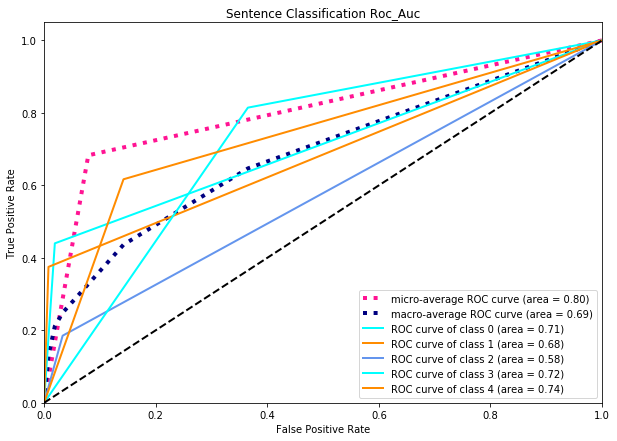

Confusion Matrix: 
 [[ 11   0   1   7   6]
 [  0   3   0   4   1]
 [  1   0   5  15   6]
 [  4   0  10 180  27]
 [  2   3   1  35  66]]


In [325]:
model_report(y_test_encoded, svc_pred, 5)

In [323]:
confusion_matrix(y_test_encoded, svc_pred)

array([[ 11,   0,   1,   7,   6],
       [  0,   3,   0,   4,   1],
       [  1,   0,   5,  15,   6],
       [  4,   0,  10, 180,  27],
       [  2,   3,   1,  35,  66]])

# Random Forest Classifier

To tackle class imabalance, we will use the follwing strategy: hyperparameter 'class_weight' = 'balanced' that comes handy for the random forest.


In [307]:
param_grid_rfc = [
                {'n_estimators': [100, 500, 700, 1000, 1200],
                'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}
                ]
rfc = RandomForestClassifier(n_jobs = -1, class_weight='balanced')

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_tfidf_reg, y_train_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700, 1000, 1200], 'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [308]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.7026687396649602
Best parameters {'max_depth': 50, 'n_estimators': 1000}


In [ ]:
param_grid_rfc = [
    {'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}
]
rfc = RandomForestClassifier(n_jobs = -1, class_weight='balanced', max_depth = , n_estimators = )

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_tfidf_reg, y_train_encoded)

In [ ]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

## Test Set Evaluation

In [309]:
rfc_final = RandomForestClassifier(n_jobs = -1, 
                                   class_weight='balanced', 
                                   n_estimators = 1000, 
                                   max_depth = 50)

rfc_final.fit(X_train_tfidf_reg, y_train_encoded)
y_pred_rfc = rfc_final.predict(X_test_tfidf_reg)


In [ ]:
model_report(y_test_encoded, y_pred_rfc, 5)

## Random Forest with Oversampling

In [132]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700, 1000, 1200],
    'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150, 170, 180]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_tfidf_over, y_train_balanced_over_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700, 1000, 1200], 'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [133]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.9698598130841122
Best parameters {'max_depth': 150, 'n_estimators': 500}


In [ ]:
param_grid_rfc = [
    {'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}
]
rfc = RandomForestClassifier(n_jobs = -1, max_depth = , n_estimators = )

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_tfidf_over, y_train_balanced_over_encoded)

In [ ]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

In [165]:
rfc_final = RandomForestClassifier(n_jobs = -1,  
                                   n_estimators = 500, 
                                   max_depth = 150)

rfc_final.fit(X_train_tfidf_over, y_train_balanced_over_encoded)
y_pred_rfc = rfc_final.predict(X_test_tfidf_over)

In [ ]:
model_report(y_test_encoded, y_pred_rfc, 5)

## Boosting With Oversampling

Another viable option to tackle class imbalance is to use an algorithm that imblements boosting, e.g. XGBoosting which is ten times faster than sklearn gradient boosting.

In [154]:

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8]
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_tfidf_over, y_train_balanced_over_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [156]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9654205607476636
Best parameters {'max_depth': 8, 'n_estimators': 700}


In [157]:
param_grid_xgb_one = [
    {'learning_rate': [1e-3, 0.5, 0.1],
     'subsample': [0.25, 0.5, 1]
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8, n_estimators=700)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_tfidf_over, y_train_balanced_over_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'learning_rate': [0.001, 0.5, 0.1], 'subsample': [0.25, 0.5, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [158]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9654205607476636
Best parameters {'learning_rate': 0.1, 'subsample': 1}


## Test Set Validation

In [159]:
xgb_final = XGBClassifier(n_jobs = -1, 
                          max_depth= 8, 
                          n_estimators = 700, 
                          subsample= 1,
                         learning_rate=0.1)

xgb_final.fit(X_train_tfidf_over, y_train_balanced_over_encoded)
y_pred_xgb = xgb_final.predict(X_test_tfidf_over)

In [ ]:
model_report(y_test_encoded, y_pred_xgb, 5)

## Latent Semantic Components

In [326]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [339]:
svd= TruncatedSVD(500)

#make a pipeline with svd and normalizer
lsa = make_pipeline(svd, Normalizer(copy=False))


X_train_lsa = lsa.fit_transform(X_train_tfidf_over)


variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Variance captured by all components:", "%.2f" %total_variance)

Variance captured by all components: 0.99


In [340]:
X_test_lsa = lsa.transform(X_test_tfidf_over)

In [331]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700, 1000, 1200],
    'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_lsa, y_train_balanced_over_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700, 1000, 1200], 'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [363]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.9789719626168224
Best parameters {'max_depth': 30, 'n_estimators': 700}


## Test Set Evaluation

In [364]:
rfc_final = RandomForestClassifier(n_jobs = -1, 
                                   n_estimators = 700, 
                                   max_depth = 30)

rfc_final.fit(X_train_lsa, y_train_balanced_over_encoded)
y_pred_rfc = rfc_final.predict(X_test_lsa)

Macro Roc_Auc:  0.6210896564624772
Micro Roc_Auc:  0.7873711340206184
Weighted Roc_Auc:  0.6210896564624772


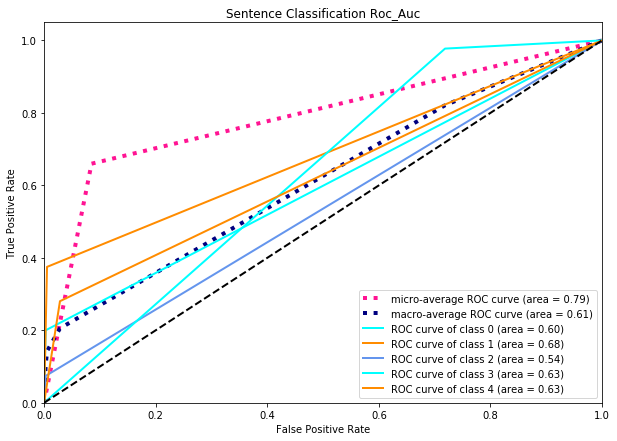

Confusion Matrix: 
 [[  5   0   0  19   1]
 [  0   3   0   5   0]
 [  0   0   2  22   3]
 [  0   0   1 216   4]
 [  1   2   0  74  30]]


In [365]:
model_report(y_test_encoded, y_pred_rfc, 5)

## Part II. Noise In The Data

Insertion, change or deletion of 1-3 letters in words (10% of the data).

In [400]:
import random
import string

In [367]:
def random_char(number):
       return ''.join(random.choice(string.ascii_letters) for x in range(number))


In [368]:
def random_generator(number, max_num):
    random_generated = []
    for num in range(number):
        rand_num = random.randint(1, max_num)
        random_generated.append(rand_num)
    return random_generated

In [404]:
def noiser(data):
    words = []
    for entry in data:
        entry_parsed = nlp(entry)
        string = ''
        # to know how many words in a sentence will be noisy
        
        # to make sure that at least one word is altered in each sentence regardless of its length
        how_many_words = np.amax([1, round(len(entry_parsed)*0.1)])
        how_many_letters = random.randint(1, 3)
        
        #one for insertion, two for replacement, three for deletion
        which_method = random.randint(1, 3)
       
        rand_numbers = random_generator(how_many_words, len(entry_parsed))
        for num, token in enumerate(entry_parsed):
            str_token = str(token)
            if num in rand_numbers:
                cutoff = random.randint(1, len(token))
                #insertion of random letters
                if which_method ==1:
                    str_token = str_token[:int(cutoff)] + random_char(how_many_letters)+ str_token[cutoff:] 

                #replacement of random letters    
                elif which_method == 2:
                    str_token = str_token[:cutoff] + random_char(how_many_letters)+ str_token[cutoff+how_many_letters:] 

                #deletion of random letters
                elif which_method == 3:
                    str_token = str_token[:cutoff] + str_token[cutoff+how_many_letters:]
            string += str_token + ' '
            string = string.replace('-', '')


        words.append(string.rstrip())
    return words

## Creation of A Noisy Data Set

In [406]:
X_train_noised = noiser(X_train)

In [407]:
X_test_noised = noiser(X_test)

In [439]:
X_train_processed_noised = processor(X_train_noised, lemmatize=False)

In [440]:
X_test_processed_noised = processor(X_test_noised, lemmatize=False)

In [441]:
X_train_processed_noised[:5]

['Importantly rl IAPP rodent species rat mouse IAPP lose capacities oJP aNRregating amyloid fibrils CITATION transgenic mouse models thiD express human IAPP develop islet deposits CITATION',
 'It obvious proofs paper bGe conditionalized',
 'case low likelod slope expected weakly positive',
 'Furthermore converted aRTk mathematical model usewkg quantitatively integrate gXrV expression data reaction constraints compute functional network states wJZkh compared reported experimental data',
 'In paper introduce radically new approach based machine learning techniques map thLj ASUvX thgEe Internet natural AS taxonomy']

## Oversampling To Tackle Class Imabalance

In [442]:
X_train_concat = pd.DataFrame({'texts': X_train_processed_noised, 'classes': y_train_encoded})

In [443]:
X_train_zero = (X_train_concat[X_train_concat['classes']==0]).sample(535, random_state=108, replace=True)
X_train_one = (X_train_concat[X_train_concat['classes']==1]).sample(535, random_state=108, replace=True)
X_train_two = (X_train_concat[X_train_concat['classes']==2]).sample(535, random_state=108, replace=True)
X_train_three = X_train_concat[X_train_concat['classes']==3]
X_train_four = (X_train_concat[X_train_concat['classes']==4]).sample(535, random_state=108, replace=True)

In [444]:
X_train_balanced_over = pd.concat([X_train_zero
                                  ,X_train_one
                                  ,X_train_two
                                  ,X_train_three 
                                  ,X_train_four], axis=0, ignore_index=True)

In [445]:
X_train_balanced_over.shape

(2675, 2)

In [446]:
#shuffle all classes 

X_train_balanced_over = X_train_balanced_over.sample(2675)

In [447]:
np.unique(X_train_balanced_over['classes'], return_counts = True)

(array([0, 1, 2, 3, 4]), array([535, 535, 535, 535, 535]))

In [448]:
y_train_balanced_over_encoded = X_train_balanced_over['classes']

In [449]:
vectorizer_noised = TfidfVectorizer(max_df=0.8, 
                             min_df=7, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [450]:
X_train_tfidf_noised=vectorizer_noised.fit_transform(X_train_balanced_over['texts'])

print("Number of features: %d" % X_train_tfidf_noised.get_shape()[1])

Number of features: 1264


In [451]:
X_test_tfidf_noised = vectorizer_noised.transform(X_test_noised)

In [452]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700, 1000, 1200],
    'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_tfidf_noised, y_train_balanced_over_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700, 1000, 1200], 'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [453]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.9698598130841122
Best parameters {'max_depth': 150, 'n_estimators': 1200}


In [454]:
param_grid_rfc = [
    {'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}
]
rfc = RandomForestClassifier(n_jobs = -1, max_depth = 150, n_estimators = 1200)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =5,
                          scoring= my_scorer, verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_tfidf_noised, y_train_balanced_over_encoded)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(multiclass_roc_auc_score), verbose=0)

In [455]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.9745327102803738
Best parameters {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


## Test Set Evaluation

In [456]:
rfc_final = RandomForestClassifier(n_jobs = -1, 
                                   n_estimators = 1200, 
                                   max_depth = 150,
                                   bootstrap=False,
                                   max_features = 'sqrt',
                                   min_samples_leaf = 1,
                                   min_samples_split = 5)

rfc_final.fit(X_train_tfidf_noised, y_train_balanced_over_encoded)
y_pred_rfc = rfc_final.predict(X_test_tfidf_noised)

Macro Roc_Auc:  0.721748559896454
Micro Roc_Auc:  0.8179768041237114
Weighted Roc_Auc:  0.721748559896454


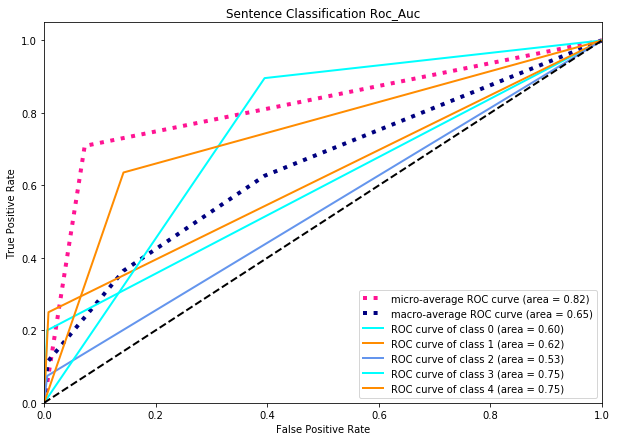

Confusion Matrix: 
 [[  5   0   0   7  13]
 [  0   2   0   4   2]
 [  0   0   2  20   5]
 [  1   0   2 198  20]
 [  1   3   0  35  68]]


In [457]:
model_report(y_test_encoded, y_pred_rfc, 5)